# Main of the paper - logistic

In this notebook are gathered all experiments generated for the main of the paper which requires logistic regression.

In [20]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "logistic"

nb_devices_for_the_run = 10
dim_notebook = 2
MAX_NB_DEVICES = 40

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


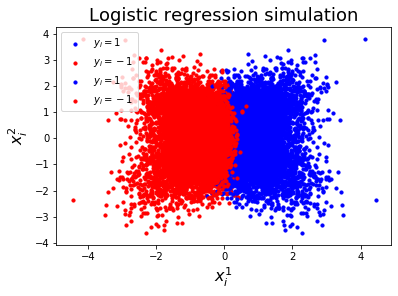

In [21]:
w = torch.FloatTensor([10, 10]).to(dtype=torch.float64)
w_true = torch.FloatTensor([10.0, 0.0]).to(dtype=torch.float64)
X_check, Y_check = build_data_logistic(w_true, n_samples = 10000, n_dimensions = dim_notebook, n_devices=10, with_seed=False)

logistic_plot(X_check[0], Y_check[0])
logistic_plot(X_check[1], Y_check[1])
plt.show()

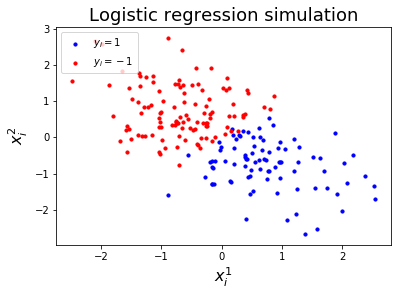

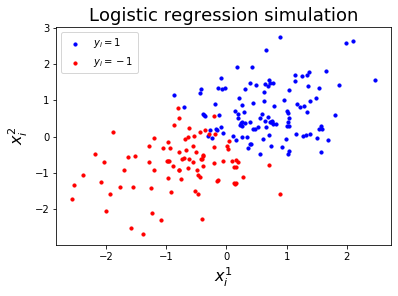

In [22]:
#w = torch.FloatTensor([0, 1000]).to(dtype=torch.float64) # Same w but different distribution (remove w modif)
w = torch.FloatTensor([10, 10]).to(dtype=torch.float64)
w_true = torch.FloatTensor([10, 0]).to(dtype=torch.float64)
X, Y = build_data_logistic(w, n_dimensions = dim_notebook,
                                             n_devices=nb_devices_for_the_run, with_seed=False)
pickle_saver((X, Y), filename + "-data")
for i in range(0, 2, 1):
    logistic_plot(X[i], Y[i])
    plt.show()

In [23]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=5000, 
                                                     quantization_param=0, 
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=LogisticModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")



  0%|          | 0/1 [00:00<?, ?it/s]

   it    |   obj   
    1000 | 3.1591e-01
    2000 | 3.1591e-01
    3000 | 3.1591e-01
    4000 | 3.1591e-01


100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

Gradient Descent: execution time=7.567 seconds
Final loss :  0.315914281139903

CPU times: user 7.57 s, sys: 0 ns, total: 7.57 s
Wall time: 7.58 s


In [24]:
obj_min_by_N

{10: 0.315914281139903}

In [25]:
obj_min_by_N_descent.model_params[-1]

tensor([3.5761, 0.0189], dtype=torch.float64)

In [29]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = LogisticModel(), use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:39<02:39, 39.99s/it]

QSGD


 40%|████      | 2/5 [02:12<02:47, 55.67s/it]

Diana


 60%|██████    | 3/5 [03:40<02:10, 65.47s/it]

DblSqz


 80%|████████  | 4/5 [05:17<01:15, 75.00s/it]

Artemis


100%|██████████| 5/5 [06:55<00:00, 83.01s/it]

CPU times: user 6min 54s, sys: 60 ms, total: 6min 54s
Wall time: 6min 55s


# With averaging

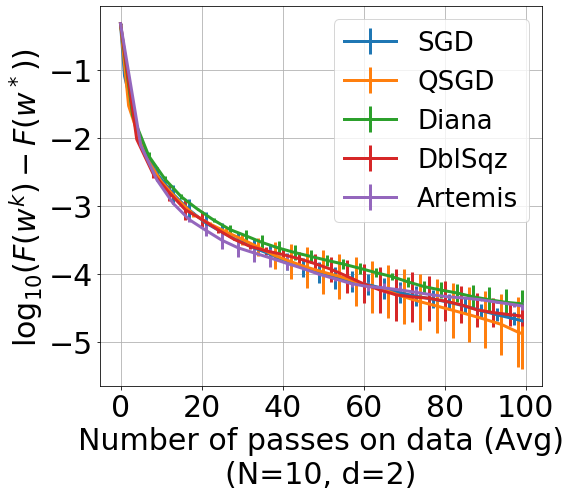

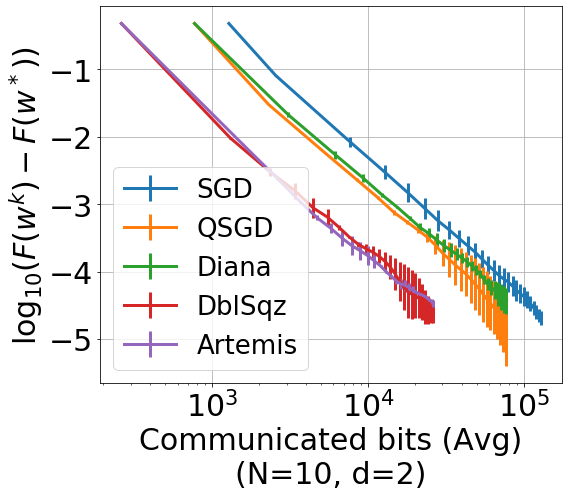

In [30]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data (Avg)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Without averaging

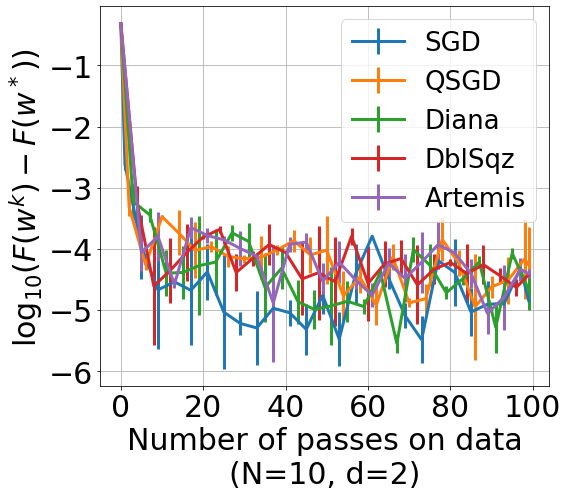

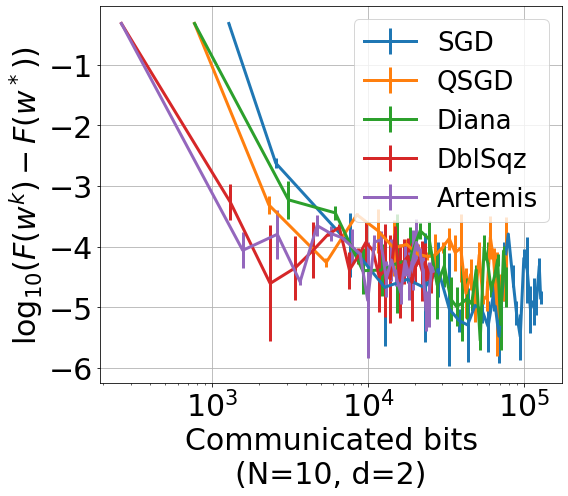

In [31]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
